In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 12분
# !unzip '/content/drive/MyDrive/input/happy-whale-and-dolphin.zip' -d '/content/data/'

In [ ]:
!kaggle datasets init -p /tmp/happywhale-tfrecords-v2

Data package template written to: /tmp/happywhale-tfrecords-v2/dataset-metadata.json


In [ ]:
!kaggle datasets create -p /tmp/happywhale-tfrecords-v2

# Cutting image

In [ ]:
from glob import glob
import os
import pandas as pd
import numpy as np
import shutil
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle

In [ ]:
train_cut = pd.read_csv('/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/train2.csv')
test_cut = pd.read_csv('/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/test2.csv')

In [ ]:
train_cut.fillna('0 0 0 0', inplace=True)
test_cut.fillna('0 0 0 0', inplace=True)

In [ ]:
shutil.copyfile('/content/data/train.csv', 'train.csv')

'train.csv'

In [ ]:
def make_croped_images(df, mode='train'):
    cnt = 0
    data_root = '/content/data/'
    os.makedirs(data_root + f'{mode}_croped', exist_ok=True)
    for i in tqdm(sorted(glob(data_root + f'{mode}_images/*'))):
        file_name = i.split('/')[-1]
        x,y,w,h = list(map(int,df[df['image']==file_name]['box'].values[0].split()))
        if (x+y+w+h) == 0:
            shutil.copyfile(f'{data_root}{mode}_images/{file_name}', 
                            f'{data_root}{mode}_croped/{file_name}')
        else:
            img = cv2.imread(f'{data_root}{mode}_images/{file_name}')
            img_ = img[y:y+h,x:x+w,:]
            cv2.imwrite(f'{data_root}{mode}_croped/{file_name}',img_)
        cnt += 1

In [ ]:
make_croped_images(train_cut, 'train')
make_croped_images(test_cut, 'test')

# Json

In [81]:
root_dir = '/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification'

In [82]:
!cp {root_dir}/kaggle.json /content/

In [83]:
import os, json, random, cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, re, math
from tqdm import tqdm

In [84]:
%%time

### Create Kaggle Dataset if not exists 

DATASET_NAME = f'happywhale-tfrecords-v2'

!rm -r /tmp/{DATASET_NAME}

os.makedirs(f'/tmp/{DATASET_NAME}', exist_ok=True)

with open('/content/kaggle.json') as f:
    kaggle_creds = json.load(f)
    
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

!kaggle datasets init -p /tmp/{DATASET_NAME}


with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json') as f:
    dataset_meta = json.load(f)
dataset_meta['id'] = f'ks2019/{DATASET_NAME}'
dataset_meta['title'] = DATASET_NAME
with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json', "w") as outfile:
    json.dump(dataset_meta, outfile)
print(dataset_meta)

!cp /tmp/{DATASET_NAME}/dataset-metadata.json /tmp/{DATASET_NAME}/meta.json
!ls /tmp/{DATASET_NAME}

!kaggle datasets create -u -p /tmp/{DATASET_NAME} 

Data package template written to: /tmp/happywhale-tfrecords-v2/dataset-metadata.json
{'id': 'ks2019/happywhale-tfrecords-v2', 'licenses': [{'name': 'CC0-1.0'}], 'title': 'happywhale-tfrecords-v2'}
dataset-metadata.json  meta.json
Starting upload for file meta.json
100% 111/111 [00:01<00:00, 62.7B/s]
Upload successful: meta.json (111B)
Dataset creation error: Dataset url's dataset slugs and hashlink are all null
CPU times: user 33 ms, sys: 379 ms, total: 412 ms
Wall time: 3.56 s


# Preprocessing - resize

In [ ]:
# from glob import glob
# import cv2
# from google.colab.patches import cv2_imshow
# from tqdm.auto import tqdm

In [ ]:
# def make_resize(image_size=256, mode='train'):
#     image_size = 256
#     directory = f'/content/data/{mode}_images_{image_size}'
#     os.makedirs(directory, exist_ok=True)
#     for i in tqdm(sorted(glob(f'/content/data/{mode}_images/*'))):
#         file_name = i.split('/')[-1]
#         img = cv2.imread(i)
#         img = cv2.resize(img, (image_size, image_size))
#         cv2.imwrite(directory+'/'+file_name, img)

In [ ]:
# make_resize(256, 'train')
# make_resize(256, 'test')

100%|██████████| 27956/27956 [32:03<00:00, 14.53it/s]


# Make tfrecords

In [ ]:
train_df = pd.read_csv(root_dir + '/skf_species_5folds.csv')
test_df = pd.read_csv('/content/drive/MyDrive/input/sample_submission.csv')
test_df['split'] = test_df.index%10
train_df.agg(['min','max','count','nunique'])

,image,species,individual_id,fold
min,00021adfb725ed.jpg,0,0,0.0
max,fffdcd42312777.jpg,29,15586,4.0
count,51033,51033,51033,51033.0
nunique,51033,30,15587,5.0


In [ ]:
def get_fold(fold):
    val_df = train_df[train_df.fold==fold].reset_index(drop=True)
    val_df['order'] = val_df.index
    val_df['order'] = val_df.groupby('individual_id').order.rank()
    val_total_counts = val_df.individual_id.value_counts().to_dict()
    val_df['total_counts'] = val_df.individual_id.map(val_total_counts)
    val_df['order'] = val_df['order']/val_df['total_counts']
    val_df = val_df.sort_values('order',ascending=False).reset_index(drop=True)
    val_df = val_df[['image','species','individual_id']]
    return val_df

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image,image_name,target,species):
    feature = {
        'image': _bytes_feature(image),
        'image_name': _bytes_feature(image_name),
        'target': _int64_feature(target),
        'species': _int64_feature(species),
      }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
def create_tf_records(fold  = 0):
    df = get_fold(fold)
    tfr_filename = f'/tmp/{DATASET_NAME}/happywhale-2022-train-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in df.iterrows():
            image_id = row.image
            target = row.individual_id
            species = row.species
            image_path = f"/content/data/train_croped/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded,image_name,target,species)
            writer.write(example)

In [ ]:
# 6분
import joblib
_ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(create_tf_records)(fold) for fold in tqdm(range(10))
    )

100%|██████████| 10/10 [00:00<00:00, 34.59it/s]


In [ ]:
from datetime import datetime
version_name = datetime.now().strftime("%Y%m%d-%H%M%S")
print(version_name)

20220311-060708


In [ ]:
def create_test_tf_records(fold  = 0):
    df = test_df[test_df.split==fold]
    tfr_filename = f'/tmp/{DATASET_NAME}/happywhale-2022-test-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in df.iterrows():
            image_id = row.image
            target = -1
            species = -1
            image_path = f"/content/data/test_croped/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded,image_name,target,species)
            writer.write(example)

In [ ]:
# 
import joblib
_ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(create_test_tf_records)(fold) for fold in tqdm(range(10))
    )

100%|██████████| 10/10 [00:00<00:00, 38.89it/s]


# Baseline


Version changes:

Version 1:

In [85]:
import os
IS_COLAB = not os.path.exists('/kaggle/input')
print(IS_COLAB) 

True


In [86]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.2.17.242:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.2.17.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.2.17.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [87]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from kaggle_datasets import KaggleDatasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from glob import glob
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

# Config

In [89]:
save_dir = '.'
EXPERIMENT = 'lrtest'
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)
if IS_COLAB:
    save_dir = f'/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/experiments-{EXPERIMENT}/{run_ts}'
    !mkdir -p {save_dir}

20220311-132114


In [93]:
class config:
    
    SEED = 42
    FOLD_TO_RUN = 0 #In this notebook, we do not train models 
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 512
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 5
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 20
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 1000
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [94]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b5


In [95]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [96]:
GCS_PATH = 'gs://kds-fb27009734a7b8596d88fb458cc700b42869b7a275824c331365255a'  # Get GCS Path from kaggle notebook if GCS Path is expired
if not IS_COLAB:
    GCS_PATH = KaggleDatasets().get_gcs_path('happywhale-tfrecords-v1')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
# tf.io.read_file
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-fb27009734a7b8596d88fb458cc700b42869b7a275824c331365255a
10 10 51033 27956


# Data

In [97]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [98]:
# row = 10; col = 8;
# row = min(row,config.BATCH_SIZE//col)
# N_TRAIN = count_data_items(train_files)
# print(N_TRAIN)
# ds = get_training_dataset(train_files)

# for (sample,label) in ds:
#     img = sample['inp1']
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

In [99]:
# row = 10; col = 8;
# row = min(row,config.BATCH_SIZE//col)
# N_TEST = count_data_items(test_files)
# print(N_TEST)
# ds = get_test_dataset(test_files)

# for (img,label) in ds:
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

# Model

In [100]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [101]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
            
        embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

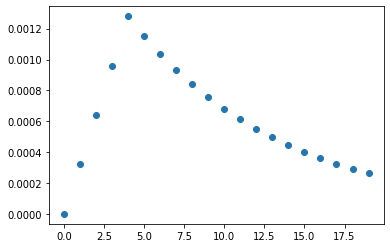

In [104]:
def get_lr_callback(plot=False):
    lr_start   = 0.000002
    lr_max     = 0.00001 * config.BATCH_SIZE  
    lr_min     = 0.000002
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [105]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

# Train

In [106]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 40826 10207


In [107]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [108]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:   
    model.load_weights(config.resume_model_wts)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b5 (Functional)   (None, None, None,   28513520    ['inp1[0][0]']                   
                                2048)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['efficientnet-b5[0][0]']        
 alAveragePooling2D)                                                                          

In [ ]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)
                


#### Image Size 512 with EfficientNet B5 and batch_size 128
Epoch 1/20
  6/318 [..............................] - ETA: 4:28 - loss: 19.3957 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0110s vs `on_train_batch_end` time: 16.3702s). Check your callbacks.


318/318 [==============================] - 489s 1s/step - loss: 19.2835 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 19.3136 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 2.0000e-06
Epoch 2/20
318/318 [==============================] - 305s 958ms/step - loss: 17.0420 - sparse_categorical_accuracy: 4.9135e-05 - sparse_top_k_categorical_accuracy: 1.9654e-04 - val_loss: 16.4776 - val_sparse_categorical_accuracy: 3.9189e-04 - val_sparse_top_k_categorical_accuracy: 0.0011 - lr: 3.2150e-04
Epoch 3/20
318/318 [==============================] - 305s 961ms/step - loss: 15.2463 - sparse_categorical_accuracy: 0.0020 - sparse_top_k_categorical_accuracy: 0.0055 - val_loss: 15.7448 - val_sparse_categorical_accuracy: 0.0097 - val_sparse_top_k_categorical_accuracy: 0.0233 - lr: 6.4100e-04
Epoch 4/20
318/318 [==============================] - 306s 962ms/step - loss: 12.9184 - sparse_catego

In [ ]:
#with open(config.save_dir+f'train_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'rb') as f:


In [ ]:
# model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss.h5")
# embed_models=[]
# for i in range(5):
#    model,embed_model = get_model()
#    embed_models.append((model.load_weights(f"/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/experiments-0/20220310-073407/effnetv1_b5_loss_{i}.h5"),embed_model))
    

In [ ]:
model,embed_model = get_model()
model, embed_model = (model.load_weights(f"/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/experiments-0/20220311-070524/effnetv1_b5_loss_0.h5"),embed_model)

# Evaluation

In [ ]:
def better_than_median(inputs, axis):
    """Compute the mean of the predictions if there are no outliers,
    or the median if there are outliers.

    Parameter: inputs = ndarray of shape (n_samples, n_folds)"""
    spread = inputs.max(axis=axis) - inputs.min(axis=axis) 
    spread_lim = 0.45
    print(f"Inliers:  {(spread < spread_lim).sum():7} -> compute mean")
    print(f"Outliers: {(spread >= spread_lim).sum():7} -> compute median")
    print(f"Total:    {len(inputs):7}")
    return np.where(spread < spread_lim,
                    np.mean(inputs, axis=axis),
                    np.median(inputs, axis=axis))

In [ ]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = np.mean(np.stack([embed_models[x][1].predict(ds,verbose=0) for x in range(5)]), axis=0)
    #print (embeddings.shape)
    return embeddings

def get_embeddings_np(filename,data_types='train',kfold_list=[x for x in range(5)],dataset='../input/eff7-new-768'):#x for x in range(6)
    ds = get_test_dataset([filename],get_names=False)

    # embeddings = np.mean(np.stack([embed_models[x][1].predict(ds,verbose=0) for x in range(5)]), axis=0)
    embeddings = embed_model.predict(ds, verbose=0)
    print (embeddings.shape)
    val_train={'train':'val','val':'train','test':'test'}
    embeddings=[]
    for kfold in kfold_list:
        path=f'{dataset}/{data_types}_{filename.split("/")[-1]}_{kfold}.npy'
        if os.path.exists(path):
            print(path)
            with open(path, 'rb') as f:
                embeddings.append(np.load(f))
        else:
            path=f'{dataset}/{val_train[data_types]}_{filename.split("/")[-1]}_{kfold}.npy'
            if os.path.exists(path):
                print(path)
                with open(path, 'rb') as f:
                    embeddings.append(np.load(f))
                
    print (len(embeddings))
    # embeddings = np.mean(np.stack(embeddings), axis=0)
    #embeddings = np.median(np.stack(embeddings), axis=0)
    #embeddings = better_than_median(np.stack(embeddings), axis=0)
    
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [ ]:
embed_model

In [ ]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES[:4]):#TRAINING_FILENAMES
    # embeddings = get_embeddings_np(filename)
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=1000)

In [ ]:
ids

array(['00021adfb725ed.jpg', '1fdc074457e490.jpg', '1febdb2e92e215.jpg',
       ..., '005e53b1b6aada.jpg', '03b2398fef7488.jpg',
       '0046ceef89b3fc.jpg'], dtype='<U18')

In [ ]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES[:1]):#(VALIDATION_FILENAMES):
    # embeddings = get_embeddings_np(filename,'val')
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2178
37c7aba965a5        85
a6e325d8e924        43
19fbb960f07d        40
9e89f8e28807        37
                  ... 
ed20b9fddaae         1
faf3cfd54449         1
7da8fd14d089         1
d5b28257276e         1
5f142fdcbcc4         1
Name: target, Length: 3291, dtype: int64

In [ ]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10207 [00:00<?, ?it/s]

394    48
393    47
339    47
376    45
360    45
       ..
658     1
657     1
643     1
633     1
114     1
Name: image, Length: 573, dtype: int64

In [ ]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.4 + 0.1*x for x in range(7)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.0: 0.6266859344893977


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.1: 0.6266859344893977


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.2: 0.6266859344893977


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.6266859344893977


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.4: 0.6267839064694114


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.5: 0.6489255739525108


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.695854152379079


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.6680301100551839


0it [00:00, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.6000000000000001
Best cv 0.695854152379079


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001
count,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000
mean,0.626686,0.626686,0.626686,0.626686,0.626784,0.648926,0.695854,0.668030
std,0.402192,0.402192,0.402192,0.402192,0.402222,0.408350,0.417174,0.412610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
50%,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 8029, True: 2178}
best_threshold 0.6000000000000001


is_new_individual,False,True,adjusted_cv
0.0,0.661052,0.500000,0.644946
0.1,0.661052,0.500000,0.644946
0.2,0.661052,0.500000,0.644946
0.30000000000000004,0.661052,0.500000,0.644946
0.4,0.661052,0.500459,0.644992
0.5,0.659557,0.609734,0.654575
0.6000000000000001,0.638633,0.906795,0.665449
0.7000000000000001,0.580531,0.990588,0.621537


# Inference

In [ ]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 512) (51033,)


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=1000)

In [ ]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    # embeddings = get_embeddings_np(filename,'test')
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/input/sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

399    120
377    117
440    116
411    115
431    115
      ... 
734      1
732      1
731      1
726      1
96       1
Name: image, Length: 642, dtype: int64

In [ ]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [ ]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:#best_threshold_adjusted
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,1e2985de58a097.jpg,3f483882f6a0 new_individual 7661d208bc83 5e62d...
1,be06475323299c.jpg,600ab1de92d9 new_individual cedc801cee3f 7ef48...
2,80d34a911209bc.jpg,47a2f9918aa2 new_individual 5a3d2040cc02 4db6b...
3,50df0a954eb94c.jpg,713eb1a00c3d new_individual 025dcdf9b2f8 77098...
4,bd8959890b900f.jpg,c995c043c353 new_individual cb37e34bc0c0 02da0...


In [ ]:
print (test_df)